# 1. torchao量化模型应用

##  1.1. 量化预训练性能体验

- TorchAO提供了一个端到端的预训练、微调和服务模型优化流程。该框架主要是量化和稀疏技术集成。

- 下面我们直接使用torchao预训练一个分类模型。最直接把torchao集成到模型训练代码中。

In [1]:
import time
import copy
import torch
from torch import nn
import torch.nn.functional as F

import torch
import torch.nn as nn
from torchao import quantize_
from torchao.quantization.quant_api import Int8WeightOnlyConfig

W0226 09:59:10.208000 11704 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


- 代码说明：
    - 代码输出的提示信息说明：这个警告信息来自 PyTorch 的分布式训练模块（torch.distributed.elastic），主要告诉你输出重定向功能在 Windows 和 macOS 上不被支持。
        - Linux/Unix使用fork()创建子进程，可以轻松继承和重定向文件描述符；Windows使用CreateProcess()，处理输出重定向的方式完全不同；MacOS虽然基于Unix，但某些特定的重定向机制与Linux不兼容。
        - PyTorch的分布式训练主要针对Linux，大多数生产环境（云服务器、集群）运行Linux。torch.distributed.elastic 主要用于大规模分布式训练；Windows/macOS 通常用于开发和调试，不是生产环境。
        - 跨平台的进程间通信（IPC）和输出捕获机制复杂；Windows 的控制台和管道机制与 POSIX 标准不同
        - 可以使用环境变量设置重定向：`os.environ['TORCH_ELASTIC_REDIRECTS'] = '0'  # 禁用重定向功能`
        - 这不是错误，只是功能限制通知。对单机单卡的情况直接忽略。对单机多卡的情况可以使用`model = nn.DataParallel(model)`。

### (1) 构建模型

In [2]:
# 模型
m = nn.Sequential(
    nn.Linear(2048, 4096),
    nn.Linear(4096, 128),
    nn.Linear(128, 1),
).bfloat16().cuda()

m2 = copy.deepcopy(m)
# 输入数据
x = torch.randn(4096, 2048, device="cuda", dtype=torch.bfloat16)
# 优化器
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
# 损失函数直接使用均方差损失mse_loss

### (2) 模型转换

In [3]:
# from torchao.quantization import Int8WeightOnlyConfig
# config = Int8WeightOnlyConfig(version=2)  # 显式指定版本
# # 或使用如下API
# from torchao.quantization.quant_api import int8_weight_only # 已经不推荐使用了。
# quantize_(m2, int8_weight_only())

quantize_(m2, Int8WeightOnlyConfig(group_size=32, version=1))
# quantize_(m2, Int8WeightOnlyConfig(group_size=None, version=2))   # 版本2中group_size只能使用None。
print(m)
print("*" * 100)
print(m2)

Sequential(
  (0): Linear(in_features=2048, out_features=4096, bias=True)
  (1): Linear(in_features=4096, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=1, bias=True)
)
****************************************************************************************************
Sequential(
  (0): Linear(in_features=2048, out_features=4096, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([4096, 2048]), block_size=(1, 32), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
  (1): Linear(in_features=4096, out_features=128, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([128, 4096]), block_size=(1, 32), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
  (2): Linear(in_features=128, out_features=1, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([1, 128]), block_size=(1, 32), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, qua

C:\Program Files\Python313\Lib\site-packages\torchao\quantization\quant_api.py:1356: UserWarning: Config Deprecation: version 1 of Int8WeightOnlyConfig is deprecated and will no longer be supported in a future release, please use version 2, see https://github.com/pytorch/ao/issues/2752 for more details
  warnings.warn(


- 代码说明：
    - 注意GPU的计算能力：
        - 测试GPU：RTX A3000 规格：
            - 架构：Ampere
            - 计算能力：8.6
            - Tensor Core：第三代 Tensor Core
            - 支持的特性：int8、int4、float16、bfloat16
    - torchao的版本与GPU的关系：
        - 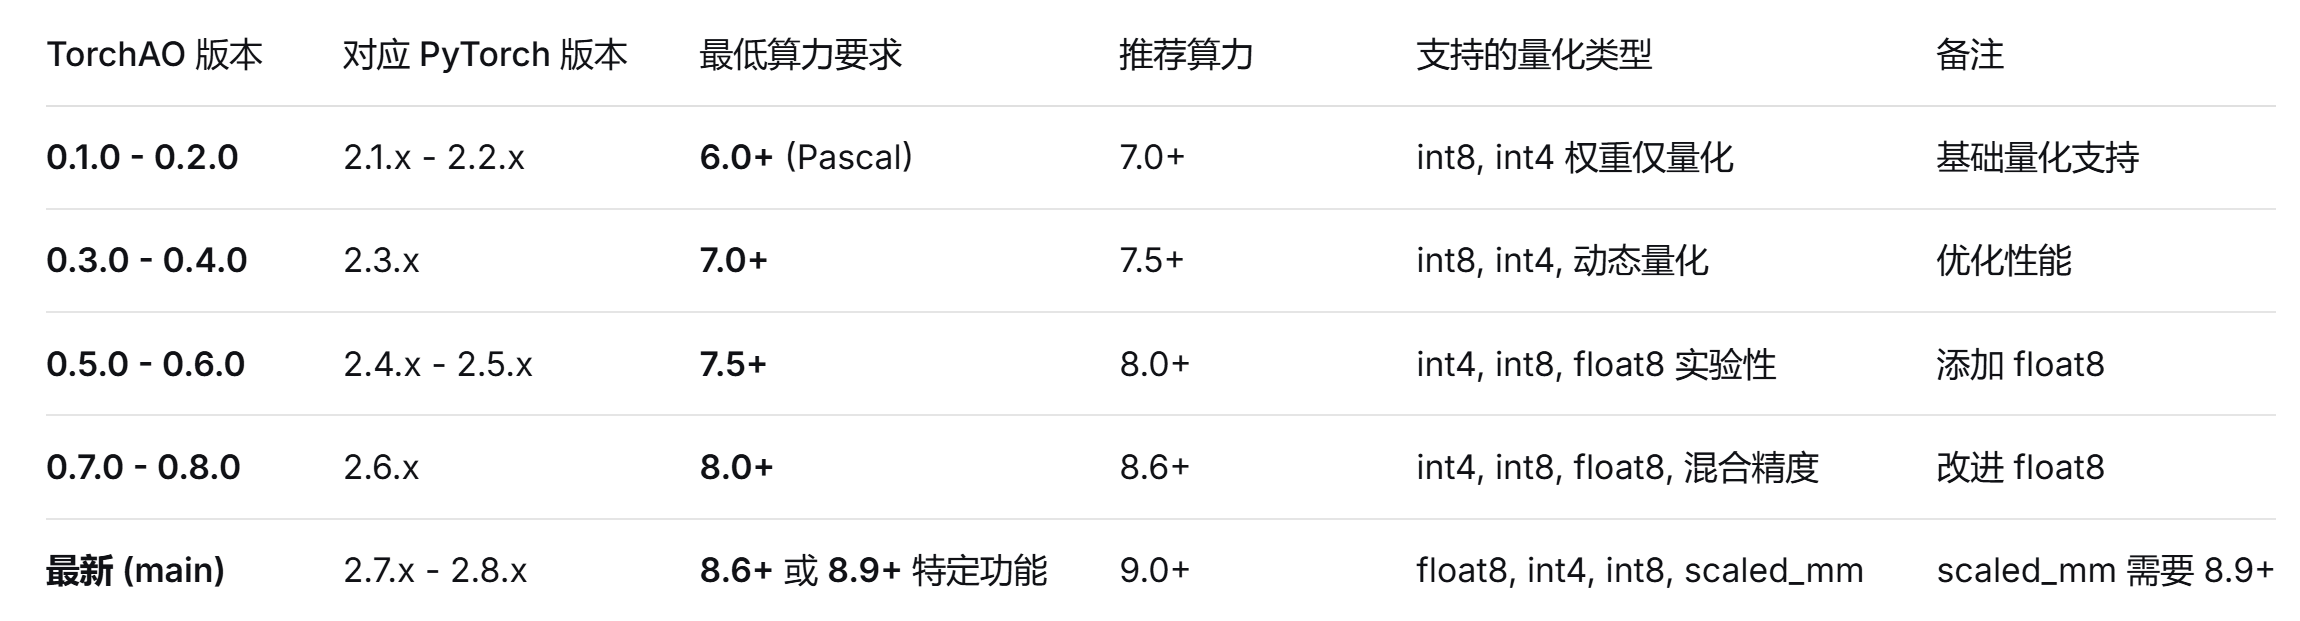
    - 我们因为GPU环境的限制，只能选择使用int8来进行量化。因为torchao16.0以上在float8采用了torch的内置运算`torch._scaled_mm`

### (3) 编译、运行与保存

In [4]:
# 启用torch.compile以提升性能
m = torch.compile(m)
m2 = torch.compile(m2)
# toy training loop
start = time.time()
for _ in range(1000):
    optimizer.zero_grad()
    output = m(x)
    # # 模拟标签
    fake_labels = torch.ones_like(output)  
    loss = F.mse_loss(output, fake_labels)
    loss.backward()
    optimizer.step()
custom_time = time.time() - start
print("普通模型运行时间：", custom_time)

start = time.time()
for _ in range(1000):
    optimizer.zero_grad()
    output = m2(x)
    # # 模拟标签
    fake_labels = torch.ones_like(output)  
    loss = F.mse_loss(output, fake_labels)
    loss.backward()
    optimizer.step()
custom_time = time.time() - start
print("量化模型运行时间", custom_time)

普通模型运行时间： 7.95224404335022
量化模型运行时间 3.391008138656616


- 代码说明：
    - torch.compile是PyTorch 2.x引入的核心编译优化功能，可以将PyTorch模型编译成更高效的版本，显著提升运行速度（通常提升30%-200%）。

## 1.2. 量化实战 - 在训练中使用量化

## 1.3. 量化实战 - 与Transformers框架结合